# Importation des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns
import pickle

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [2]:
#Ce code permet de faire fonctionner tout le fichier dans VSCode et dans Google Collab sans avoir besoin de changer le code
def check_and_mount_drive():
    error = False
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        error = True
    return error

error_detected = check_and_mount_drive()


Mounted at /content/drive


# Importation des bibliothèque

In [3]:
from time import time

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
#from drive.MyDrive.RNN_sentiment_dataset.random_tweets import *

# TF IDF Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csc_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# CNN Imports
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dense, Dropout, Flatten, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


In [4]:
if error_detected == True:
    file_path = "C:/Users/titou/OneDrive/Documents/ISEN/4 eme année/NLP/Projet/data_classification_commentaires_toxiques/train.csv"
else:
    file_path = "/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv"
randomnumber = random.randint(0, 1000000)
print (randomnumber) #Prend un nombre aléatoire pour la selection des données
data = pd.read_csv(file_path).sample(n=50000, random_state=randomnumber) #On prend 10000 données aléatoires
data.head()

600965


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
61635,a4f973688b7ddf52,Have you had a chance to talk to Dan yet? \n\n...,0,0,0,0,0,0
70230,bbe45f1faa608911,"""\nAgreed. Considering your response, I unders...",0,0,0,0,0,0
156986,d69ca809e8c9b6cb,Seems a reasonable request reasonable to me.,0,0,0,0,0,0
6852,124b1d7e68057f21,"""\nGiven the recent talk page comment I think ...",0,0,0,0,0,0
12916,2236737a61b52b0c,The Transporter \n\nNice work.,0,0,0,0,0,0


# Préparation des données

In [5]:
# Télécharger les stopwords (si ce n'est pas déjà fait)
nltk.download('stopwords')
nltk.download('punkt_tab')

# Fonction améliorée pour nettoyer les commentaires
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+|www.\S+', '', text)  # Enlever les URLs
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions (@user)
    text = re.sub(r'[^a-z\s]', '', text)  # Supprimer tout sauf les lettres et espaces
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer espaces inutiles
    return text

# Appliquer le nettoyage sur la colonne 'comment_text'
data['cleaned_comment_text'] = data['comment_text'].apply(clean_text)

# Tokenize the 'cleaned_comment_text' column
# This creates the 'tokenized_comment_text' column
from nltk.tokenize import word_tokenize
data['tokenized_comment_text'] = data['cleaned_comment_text'].apply(word_tokenize)

# Supprimer les stopwords
stop_words = set(stopwords.words('english'))
data['tokenized_comment_text'] = data['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Convertir le texte en séquences numériques
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_comment_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_comment_text'])

# Calculer la longueur maximale de commentaire pour le padding
max_length = int(data['cleaned_comment_text'].apply(lambda x: len(x.split())).median())
print(f"Longueur médiane des commentaires : {max_length}")

# Appliquer le padding sur les séquences pour qu'elles aient toutes la même longueur
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Afficher les 5 premières séquences pour voir le résultat
print(padded_sequences[:5])

print("Exemple de texte AVANT nettoyage :")
print(data['comment_text'].iloc[0])

print("\nExemple de texte APRÈS nettoyage :")
print(data['cleaned_comment_text'].iloc[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Longueur médiane des commentaires : 35
[[   15    75 45455    26     7    18    56 45456     2   898    12  2603
      2   252    35    70    54    49    53    47    51   115    21     4
     69  1688    53   486    32     9   346     6 45457     2 45458]
 [ 4128   141    52    19    37   492     4     7    73    14     7   133
    579     2   104    74  1566     3    85   193    28   304    86    16
   2444     4    86    16  1084   470    22     6   440 20928   691]
 [  196     5  1102   288  1102     2    35     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [  321     1   468    41    27   205     7    68    58  2048     2 31292
   1405     1  2994   696  9707     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    1 45459   471   139     0     0     0     0     0     0     0     0
      0     0     0

# Etude du jeu de données

Informations de base sur le dataset :
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 61635 to 146621
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      50000 non-null  object
 1   comment_text            50000 non-null  object
 2   toxic                   50000 non-null  int64 
 3   severe_toxic            50000 non-null  int64 
 4   obscene                 50000 non-null  int64 
 5   threat                  50000 non-null  int64 
 6   insult                  50000 non-null  int64 
 7   identity_hate           50000 non-null  int64 
 8   cleaned_comment_text    50000 non-null  object
 9   tokenized_comment_text  50000 non-null  object
dtypes: int64(6), object(4)
memory usage: 4.2+ MB
None

Vérification des valeurs manquantes :
id                        0
comment_text              0
toxic                     0
severe_toxic              0
obscene                

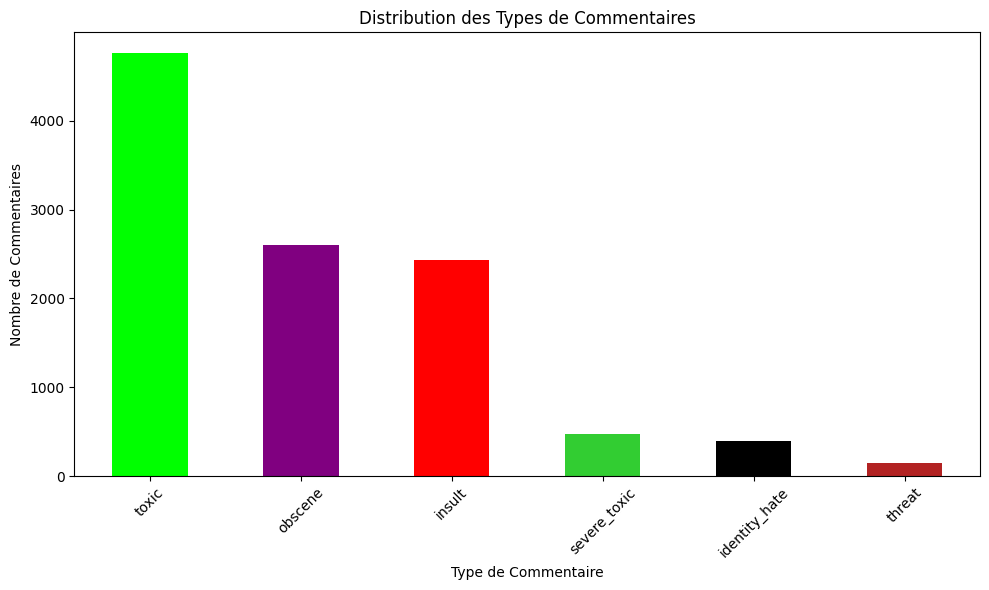

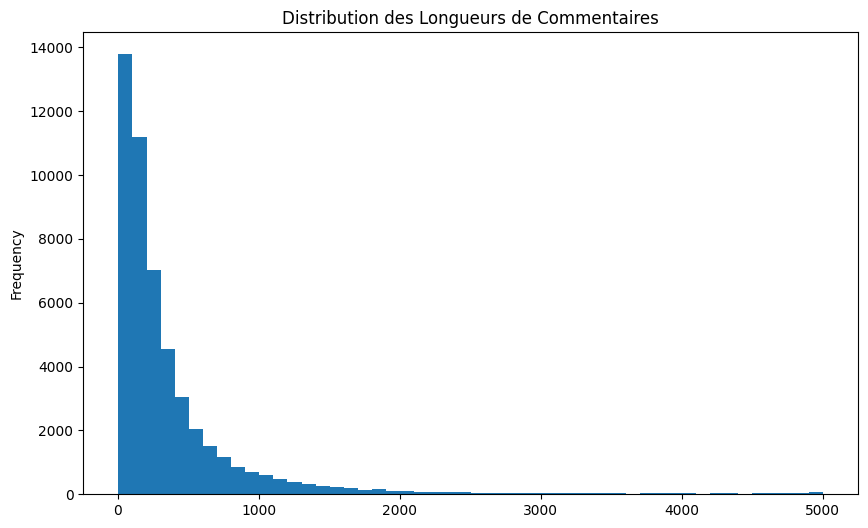

In [6]:
# Affichage des informations de base sur le dataset
print("Informations de base sur le dataset :")
print(data.info())

# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes :")
print(data.isnull().sum())

# Supprimer les lignes où le commentaire est devenu vide après nettoyage
data = data[data['cleaned_comment_text'].str.strip() != '']
print(f"\nDonnées après suppression des commentaires vides : {data.shape}\n")


# Distribution des types de commentaires
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Liste des couleurs pour chaque type de commentaire
colors = ['#00FF00', '#800080', '#FF0000', '#32CD32', '#000000', '#B22222']

# Création d'un graphique pour la distribution des types de commentaires avec des couleurs différentes
plt.figure(figsize=(10, 6))
data[target_columns].sum().sort_values(ascending=False).plot(kind='bar', color=colors)
plt.title('Distribution des Types de Commentaires')
plt.xlabel('Type de Commentaire')
plt.ylabel('Nombre de Commentaires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Affichage de la distribution des longueurs de commentaires
data['comment_length'] = data['comment_text'].apply(len)
data['comment_length'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution des Longueurs de Commentaires')
plt.show()

# Entraînement du modèle baseline

##### A utilisé beaucoup trop de ram, on va tester autre choses

In [ ]:
"""# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_columns))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))"""

'# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)\n\n# Initialize the RandomForestClassifier\nrf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Train the model\nrf_classifier.fit(X_train, y_train)\n\n# Make predictions on the test set\ny_pred = rf_classifier.predict(X_test)\n\n# Evaluate the model\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred, target_names=target_columns))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))\n\nprint("Accuracy Score:")\nprint(accuracy_score(y_test, y_pred))'

In [17]:
# Fonction pour traiter chaque chunk
def process_chunk(chunk, chunk_index):
    start_time = time()
    tweet_tokenizer = TweetTokenizer()  # Définir le tweet_tokenizer

    # Nettoyage du texte
    chunk['cleaned_comment_text'] = chunk['comment_text'].apply(clean_text)

    # Supprimer les commentaires vides après nettoyage (en maintenant les indices)
    chunk = chunk[chunk['cleaned_comment_text'].str.strip() != ""].reset_index(drop=True)

    # Tokenisation
    chunk['tokenized_comment_text'] = chunk['cleaned_comment_text'].apply(tweet_tokenizer.tokenize)

    # Suppression des stopwords
    chunk['tokenized_comment_text'] = chunk['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

    # Conversion en séquences de tokens
    sequences = tokenizer.texts_to_sequences(list(chunk['cleaned_comment_text']))  # Utilisation de `list()` pour accélérer

    # Supprimer les lignes avec NaN dans les labels et ré-aligner les indices
    chunk = chunk.dropna(subset=target_columns).reset_index(drop=True)

    # Padding
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Vérification du nombre de lignes après traitement et nettoyage
    print(f"✅ Chunk {chunk_index} traité en {time() - start_time:.2f} sec - {len(chunk)} commentaires")
    print(f"✅ Taille des séquences après padding: {padded_sequences.shape[0]}")

    return padded_sequences, chunk[target_columns].values

# Paramètres de traitement en chunks
chunk_size = 10000
padded_sequences_list = []
y_list = []

# Lecture et traitement des données en chunks
for chunk_index, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, nrows=chunk_size * 5)):
    padded_sequences_chunk, y_chunk = process_chunk(chunk, chunk_index)
    padded_sequences_list.append(padded_sequences_chunk)
    y_list.append(y_chunk)

# Concaténation des résultats finaux
padded_sequences = np.concatenate(padded_sequences_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Vérifier la taille des données
print("✅✅ Traitement terminé ! Nombre total de séquences:", padded_sequences.shape[0])
print("📊 Taille de padded_sequences:", padded_sequences.shape[0])
print("📊 Taille de y:", y.shape[0])

# Vérification de la correspondance des tailles
assert padded_sequences.shape[0] == y.shape[0], "Les tailles de X et y ne correspondent pas !"

print("🔹 Exemple final de séquences après traitement:", padded_sequences[:5])

# Sauvegarder le tokenizer dans un fichier
with open('/content/drive/My Drive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


✅ Chunk 0 traité en 7.57 sec - 9997 commentaires
✅ Taille des séquences après padding: 9997
✅ Chunk 1 traité en 7.37 sec - 9999 commentaires
✅ Taille des séquences après padding: 9999
✅ Chunk 2 traité en 5.39 sec - 10000 commentaires
✅ Taille des séquences après padding: 10000
✅ Chunk 3 traité en 4.25 sec - 10000 commentaires
✅ Taille des séquences après padding: 10000
✅ Chunk 4 traité en 5.89 sec - 9999 commentaires
✅ Taille des séquences après padding: 9999
✅✅ Traitement terminé ! Nombre total de séquences: 49995
📊 Taille de padded_sequences: 49995
📊 Taille de y: 49995
🔹 Exemple final de séquences après traitement: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


# Itération de la modélisation

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 54ms/step - accuracy: 0.6186 - loss: 0.1437
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.9189 - loss: 0.0559
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 58ms/step - accuracy: 0.9039 - loss: 0.0415
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - accuracy: 0.8581 - loss: 0.0345
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 52ms/step - accuracy: 0.6522 - loss: 0.0293
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.6226 - loss: 0.0259
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - accuracy: 0.5340 - loss: 0.0191
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.4371 - loss: 0.0187
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.4692 - loss: 0.0152
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 59ms/step - accuracy: 0.5152 - loss: 0.0151
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report with CNN:
               precision  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


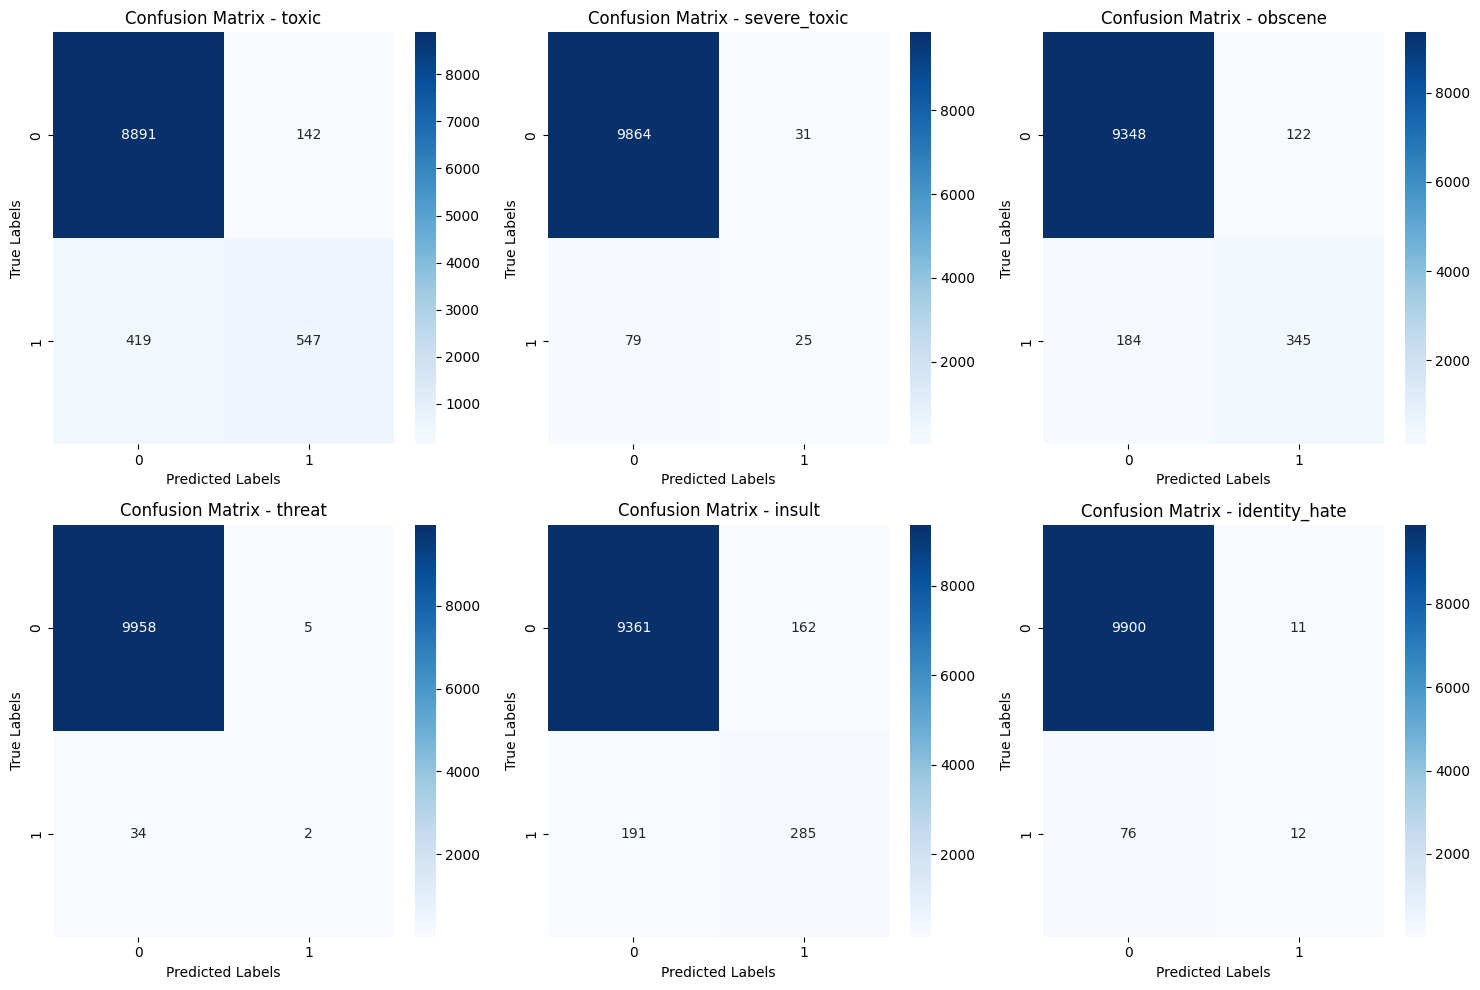

Accuracy Score with CNN:
0.9026902690269026
Le modèle a été sauvegardé avec succès sous le nom 'modele_entraine.h5'.


In [8]:
# Ajuster le Tokenizer sur ton ensemble de texte
tokenizer.fit_on_texts(data['cleaned_comment_text'])

# Obtenir la taille du vocabulaire
vocab_size = len(tokenizer.word_index) + 1  # Ajouter 1 car l'index commence à 1

# Définition du modèle CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Découper les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Calculer l'accuracy pour chaque classe
accuracies_per_class = []

for i in range(y_test.shape[1]):  # Pour chaque colonne (chaque classe)
    acc = accuracy_score(y_test[:, i], y_pred_best_binary[:, i])
    accuracies_per_class.append(acc)

# Afficher les accuracies par classe
for i, class_name in enumerate(target_columns):
    print(f"Accuracy for {class_name}: {accuracies_per_class[i]:.4f}")

# Matrice de confusion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes
#axes = axes.ravel() # Remove this line to keep axes as a 2D array

# Boucle pour chaque colonne (chaque type de commentaire)
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))

# Enregistrement du modèle entraîné dans un fichier .h5
model.save('modele_entraine.h5')

# Vérification de l'enregistrement
print("Le modèle a été sauvegardé avec succès sous le nom 'modele_entraine.h5'.")

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Enregistrer le modèle sur Google Drive
model.save('/content/drive/My Drive/mon_modele.h5')

# Vérification
print("Le modèle a été sauvegardé sur Google Drive sous le nom 'mon_modele.h5'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Le modèle a été sauvegardé sur Google Drive sous le nom 'mon_modele.h5'.


In [16]:
import re
import pickle
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 1. Charger le modèle préalablement entraîné
model = load_model('/content/drive/My Drive/mon_modele.h5')

# Recompiler le modèle pour s'assurer qu'il est prêt à être utilisé
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Charger le tokenizer sauvegardé lors de l'entraînement
with open('/content/drive/My Drive/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Définir la longueur maximale des séquences (doit correspondre à celle utilisée à l'entraînement)
MAXLEN = 100  # Ajuste cette valeur si elle est différente dans ton entraînement

# Charger les noms des catégories (les étiquettes de classification)
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Exemple de nettoyage du texte (doit être cohérent avec ce qui a été fait avant l'entraînement)
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+', '', text)  # Supprimer les liens URL
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Supprimer les hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Supprimer la ponctuation et les chiffres
    text = text.strip()  # Supprimer les espaces superflus
    return text

# 3. Fonction de classification
def classify_text(input_text):
    # Nettoyer le texte
    cleaned_text = clean_text(input_text)

    # Tokeniser le texte
    text_sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Appliquer le padding
    padded_text = pad_sequences(text_sequence, maxlen=MAXLEN, padding='post')

    # Vérification de la forme de l'entrée
    print("Shape de l'entrée après padding:", padded_text.shape)

    # Prédiction avec le modèle
    prediction = model.predict(padded_text)

    # Convertir la prédiction en binaire (0 ou 1) avec un seuil de 0.5
    prediction_binary = (prediction > 0.5).astype(int)

    # Associer les prédictions aux labels des classes
    result = {target_columns[i]: 'Toxic' if prediction_binary[0][i] == 1 else 'Non Toxic' for i in range(len(target_columns))}

    return result

# 4. Exemple d'utilisation de la fonction
input_text = "You are so stupid and awful!"

# Appeler la fonction de classification
result = classify_text(input_text)

# Afficher le résultat
print("Résultat de la classification :")
for label, prediction in result.items():
    print(f"{label}: {prediction}")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 1024, but received input with shape (1, 3136)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 100), dtype=int32)
  • training=False
  • mask=None